# Moment dynamics with cell division

---
(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import pickle
import cloudpickle
import itertools
import glob

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Distribution moment dynamics with cell division 

As first discussed by [Jones et al.](http://science.sciencemag.org/content/346/6216/1533) and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the genome replication origin.

For our experimental setup our cells spend 40% of the cell cycle with 2 copies of the reporter gene and 40% with one copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell doubling time $t_d \approx 100$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

### Cell division

After cells reach time $t_d$ the content of the cells is assumed to divide as the cells split into two daughter cells. To account for this division we will assume that the mean mRNA (and later on protein) count are halved. Given the dependence of higher moments on the first moment we will "re-initialize" the value of the other moments assuming the values that one would obtain if this halved mean mRNA count was the steady state value. 

In other words assume that the mean mRNA count at time $t_d$ is given by $\ee{m(t_d)}$. After this time we reset the initial condition for the simulation with one promoter to be $\ee{m(t=0)} = {\ee{m(t_d)} \over 2}$. By fixing the first moment values higher moments of the mRNA distirbution $\ee{m^x}$ will be computed by finding what the steady state value would be given the value of the first moment. Note that this will not strictly give the same values as just computing the steady state value of the moments. If the initial condition $\ee{m(t=0)}$ is not the same as steady state condition $\ee{m}_{ss}$ the values that the other moments will also differ from the steady state values.

The reason for this convoluted assumption is that dividing the first moment in half after cell division makes sense, but it is not clear that the same assumption applies for higher moments of the distribution. To gain intuition about this assume that the mRNA distribution is binomial with mean value $\ee{m(t_d)} = N p$. Dividing this by half for the initial condition is easy since we would have $\ee{m(t=0)} = {N p \over 2}$. The second moment before the cell division would be of the form $\ee{m^2(t_d)} = Np - Np^2 + N^2p^2$. Therefore dividing this value by two for the initial condition of the next cell cycle doesn't translate to the second moment one would expect for a binomial distribution with mean ${Np \over 2}$.

# Defining promoter parameters

Before starting all the calculations we will define the kinetic parameters for the promoter.

In [3]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / (60 * 100) # sec^-1
rp = 1000 * gp # sec^-1

## Defining moment dynamics 

Let's begin by working with the mRNA dynamics only. We have already on the `moment_dynamics_system.ipynb` notebook established the dynamics for the first 6 mRNA moments. In general we established that the moment dynamics are of the form
$$
\dt{\mu} = \bb{A \mu},
$$
where $\mu$ is the array containing all of our moments, and the matrix $\bb{A}$ contains the linear coefficients of our linear system.

Let us begin by defining a function `dmomdt` that takes as input an array of moments `m`, a time array `t` and a matrix `A` and returns the right-hand side of the equation for the moment dynamics. This function will be fed to the `scipy.integrate.odeint` function.

In [4]:
def dmomdt(mom, t, A):
    '''
    Function that computes the right-hand side of the moment
    dynamics equation
    dµ/dt = Aµ
    This funciton is fed to the scipy.integrate.odeint function
    Parameters
    ----------
    mom : array-like
        Array containing all of the moments included in the matrix
        dynamics A.
    t : array-like
        time array
    A : 2D-array.
        Matrix containing the linear coefficients of the moment
        dynamics equation
    Returns
    -------
    Right hand-side of the moment dynamics
    '''
    return np.dot(A, mom)

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [5]:
def dmomdt_cycles(mom_init, t_single, t_double,
                  A_mat_s, A_mat_d, expo, 
                  n_cycles, n_steps=1000, t_ss=10000,
                  states=['P', 'E']):
    '''
    Function that integrates the moment dynamics over several cell 
    cycles.
    Parameters
    ----------
    mom_init : array-like.
        Array containing the  initial conditions for the moment 
        of the states of the promoter.
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    A_mat_s, A_mat_d : 2D-array
        Square matrices defining the moment dynamics.
        A_mat_s = dynamics when cells have a single promoter
        A_mat_d = dynamics when cells have two promoters
    expo : array-like
        List containing the moments involved in the 
        dynamics defined by A
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.
    states : array-like. Default = ['P', 'E']
        Array containing the strings that define the moments that the
        promoter can be found at. For an unregulated promoter the only
        two available states are 'P' (RNAP bound) and 'E' (empty).
        For the regulated case a third state 'R' (repressor bound) is
        available to the system.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m{0:d}p{1:d}'.format(*x) + s for x in expo 
             for s in states]
    
    ## Generate matrix to be used for the initial condition
    ## after the cell division computation. What this means is
    ## that we will turn to zero the rows that correspond to the
    ## zeroth moment and the fisrt moments
    # Find location of moments in matrix
    idx = [i for i, e in enumerate(expo) if sum(e) <= 1]
    # Adjust index depending on number of states
    idx = [i * len(states) + s for i in idx
           for s in range(len(states))]
    # Loop through rows and convert them to zeros
    A_mat_init = A_mat_s.copy()
    for i in idx:
        A_mat_init[i, :] = 0
    
    # Find and save index of first moment. This will
    # be used to indicate which quantities will be
    # divided in half after the cell division
    mean_idx = [i for i, e in enumerate(expo) if sum(e) == 1]
    # Adjust index depending on number of states
    mean_idx = [i * len(states) + s for i in mean_idx
                for s in range(len(states))]
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    
    ###  Loop through cycles  ###
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        mom = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_s,))

        # Generate data frame
        df_mom = pd.DataFrame(mom, columns=names)
        # Append time, state and cycle
        df_mom = df_mom.assign(time=t + t_sim)
        df_mom = df_mom.assign(state=['single'] * mom.shape[0])
        df_mom = df_mom.assign(cycle=[cyc] * mom.shape[0])
        
        # Append results to global data frame
        df = df.append(df_mom, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last 
        # point of single promoter state
        mom_init = mom[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        mom = sp.integrate.odeint(dmomdt, mom_init, t, 
                                  args=(A_mat_d,))

        # Generate data frame
        df_mom = pd.DataFrame(mom, columns=names)
        # Append time, state and cycle
        df_mom = df_mom.assign(time=t + t_sim)
        df_mom = df_mom.assign(state=['double'] * mom.shape[0])
        df_mom = df_mom.assign(cycle=[cyc] * mom.shape[0])
        
        # Append results to global data frame
        df = df.append(df_mom, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)

        # Define initial conditions as last point
        mom_fix = mom[-1, :]
        # Divide mean in half
        for i in mean_idx:
            mom_fix[i] = mom_fix[i] / 2

        # Define initial conditions for 
        # moments after cell division
        mom = sp.integrate.odeint(dmomdt, mom_fix, t, 
                             args=(A_mat_init,))

        mom_init = mom[-1, :]
        
    return df

# Two-state promoter

Having defined these functions let's first test them with the two-state unregulated promoter.

First we need to import the matrix $\bb{A}$ that define the two-state dynamics of the first 6 mRNA moments.

In [6]:
# Read protein ununregulated matrix 
with open('./two_state_mRNA_dynamics_matrix.pkl', 'rb') as file:
    A_mat_unreg_lam = cloudpickle.load(file)
    expo = cloudpickle.load(file)
    
# Substitute value of parameters on matrix
# Single promoter
A_mat_unreg_s = A_mat_unreg_lam(kp_on, kp_off, rm, gm)
# Two promoters
A_mat_unreg_d = A_mat_unreg_lam(kp_on, kp_off, 2 * rm, gm)

Let's integrate the equations for a long time to obtain the initial condition. For this we will initialize the moments. Running the integration for a long time will allow all of the moments to reach their steady state that we will use as our inital condition for the actual cell cycle integration.

In [7]:
# Define time on which to perform integration
t = np.linspace(0, 300 * 60, 3000)

# Define initial conditions
mom_init = np.zeros(len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Numerically integrate equations
m = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_unreg_s,))

# Define the inital conditions as the last point in this integration.
m_init = m[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [8]:
# Define time for single-promoter state
t_single = 60 * 0.6 * 100 # sec

# Define time for two-promoter state
t_double = 60 * 0.4 * 100 # sec

# Define number of cell cycles
n_cycles = 4

# Integrate moment equations
df_m_unreg = dmomdt_cycles(m_init, t_single, t_double, 
                   A_mat_unreg_s, A_mat_unreg_d, expo,
                   n_cycles, n_steps=1500)

Now let's plot the first mRNA moment. For this we first need to extract all the first moments for each of the promoter states and add them together to get the global first moment.

In [9]:
# Extract index for first and second moment
first_mom_names = [x for x in df_m_unreg.columns if 'm1p0' in x]

# Compute the mean mRNA copy number
m_mean = df_m_unreg.loc[:, first_mom_names].sum(axis=1)

Now we can plot the mean.

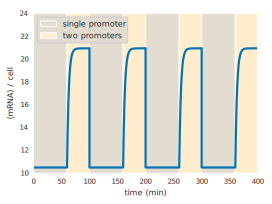

In [10]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean mRNA as solid line
ax.plot(df_m_unreg.time / 60, m_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_m_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_m_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df_m_unreg['time'].min() / 60, 
            df_m_unreg['time'].max() / 60)
ax.set_ylim(top=24)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(figdir + 'mean_mRNA_cycles.pdf', bbox_inches='tight')

We can see from this plot that the mRNA indeed seems to reach a steady state both when cells have one copy of the promoter, and when cells have two copies. This was expected given that the way that the mRNA production parameters were inferred in the first place assumed this steady state. This is just a confirmation that our numerical integration of the moment equations makes sense with what we expect.

It is important to highlight that we do not necessarily expect the same result for proteins since the time to steady state is set by the degradation rate, and the protein degradation rate for bacteria is assumed to be the dilution rate due to cell division.

## Defining Protein dynamics 

Having worked out the mRNA dynamics let's extend this approach to the protein dynamics. Let's import the matrix $\bb{A}$ that defines the two-state promoter dynamics up to the 6th protein moment.

In [11]:
# Read protein ununregulated matrix 
with open('./two_state_protein_dynamics_matrix.pkl', 'rb') as file:
    A_mat_unreg_lam = cloudpickle.load(file)
    expo = cloudpickle.load(file)
    
# Substitute value of parameters on matrix
# Single promoter
A_mat_unreg_s = A_mat_unreg_lam(kp_on, kp_off, rm, gm, rp, gp)
# Two promoters
A_mat_unreg_d = A_mat_unreg_lam(kp_on, kp_off, 2 * rm, gm, rp, gp)

We can now run the integration to compute the initial conditions for the simulation. As a reminder, we select arbitrary initial conditions for the moments, run the integration for a long time such that all moments reach the steady state that they would have if the cells kept one promoter at all times during the cell cycle, and we use those steady state values as the initial condition for our numerical integration over the cell cycle.

In [12]:
# Define time on which to perform integration
t = np.linspace(0, 4000 * 60, 100000)

# Define initial conditions
mom_init = np.zeros(len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Numerically integrate equations
mp_sol = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_unreg_s,))

mp_init = mp_sol[-1, :]

print('<m> = {:.1f}'.format(mp_init[2:4].sum()))
print('<p> = {:.1f}'.format(mp_init[14:16].sum()))

<m> = 10.5
<p> = 10456.9


Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [13]:
# Define time for single-promoter state
t_single = 60 * 0.6 * 100  # sec

# Define time for two-promoter state
t_double = 60 * 0.4 * 100  # sec

# Define number of cell cycles
n_cycles = 5

# Integrate moment equations
df_p_unreg = dmomdt_cycles(mp_init, t_single, t_double, 
                           A_mat_unreg_s, A_mat_unreg_d, expo,
                           n_cycles, n_steps=10000)

Now let's plot the first moment. Just as before we first extract the first moments for each of the promoter states and add them together.

In [14]:
# Extract index for first moment
first_mom_names_m = [x for x in df_p_unreg.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names_m].sum(axis=1)
p_mean = df_p_unreg.loc[:, first_mom_names_p].sum(axis=1)

Let's first plot the protein first moment.

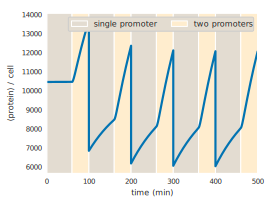

In [15]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean protein as solid line
ax.plot(df_p_unreg.time / 60, p_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df_p_unreg['time'].min() / 60, 
            df_p_unreg['time'].max() / 60)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig(figdir + 'mean_protein_cycles.pdf', bbox_inches='tight')

For the protein case we can se that as expected the system does not reach the steady state for either of the two promoter copy numbers. What this means is that given the slower degradation rate of the protein the system doesn't have enough time to relax into the one- or two-promoter steady state.

But interestingly enough, the protein reaches some sort of "dynamic steady state" in which after several cell cycles the system reproducibly repeats the pattern of expression over and over again.

Let's plot both first moments side to side.

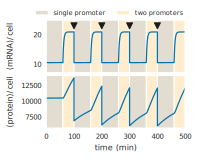

In [16]:
# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Plot mean mRNA as solid line
ax[0].plot(df_p_unreg.time / 60, m_mean, label='', lw=1.25)
ax[1].plot(df_p_unreg.time / 60, p_mean, label='', lw=1.25)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')

# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label='')
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label='')

##  Indicate where the cell divisions happen
# First find where the cell cycle transition happen
trans_idx = np.array(np.diff(df_p_unreg.cycle) == 1)
trans_idx = np.insert(trans_idx, 0, False)  # Add extra point to have same length
# Get the time points at which this happens
time_div = df_p_unreg[trans_idx].time.values
# Plot with a triangle the cell division moment
ax[0].plot(time_div / 60, [np.max(m_mean) * 1.1] * len(time_div),
           lw=0, marker='v', color='k')

# Set limits
# mRNA
ax[0].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)
ax[0].set_ylim([7, 25])
#protein
ax[1].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)

# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$/cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$/cell')

# Align y axis labels
fig.align_ylabels()

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

plt.subplots_adjust(hspace=0.05)
plt.savefig(figdir + 'first_mom_cycles.pdf', bbox_inches='tight',
            transparent=True)
plt.savefig(figdir + 'first_mom_cycles.svg', bbox_inches='tight',
            transparent=True)

# Moment dynamics with cells exponentially distributed along cell cycle

As first discussed by Powell in 1956 populations of cells in a log-phase are exponentially distributed along the cell cycle. This distribution is of the form
$$
P(a) = (\ln 2) \cdot 2^{1 - a},
$$
where $a \in [0, 1]$ is the stage of the cell cycle, with $a = 0$ being the start of the cycle and $a = 1$ being the division.

Our numerical integration of the moment equations gave us a time evolution of
the moments along the cell cycle. Without loss of generality let's focus on the
first mRNA moment $\ee{m(t)}$ (the same can be applied to all other moments).
In order to calculate the first moment along the entire cell cycle we must
average each time point by the corresponding probability that a cell is found
in such time point. This translates to computing the integral
$$
  \ee{m} = \int_{\text{beginning cell cycle}}^{\text{end cell cycle}}
                       \ee{m(t)} P(t) dt.
$$

If we map each time point in the cell cycle into a fraction we can use
the distribution and compute instead
$$
  \ee{m} = \int_0^1 \ee{m(a)} P(a) da.
  \label{eq_moment_avg}
$$

In this section we will compare the simple repression thermodynamic model of gene expression with this dynamical picture of the cell cycle.

## Three-state promoter

Let's now include the regulation given by the repressor. For this we change to the three-state promoter that includes two new parameters $\kron$ and $\kroff$. At the mRNA level by assumption our parameter inference assumed that the promoter quickly relaxed from the steady state with one promoter to the steady state with two promoters. This is clearly reflected in the dynamics as we saw in the previous section. Therefore, if we ignore the transients between the single promoter and the two promoters state, the fold-change is of the form. 
$$
\foldchange = 
{ f \cdot \ee{m(R \neq 0)}_1 + (1 - f) \cdot \ee{m(R \neq 0)}_2
\over
f \cdot \ee{m(R = 0)}_1 + (1 - f) \cdot \ee{m(R = 0)}_2},
$$
where $f \in [0, 1]$ is the fraction of the cell cycle that cells spend with a single copy of the promoter.

Just as our reporter gene changes in copy number and therefore the protein copy number changes along the cell cycle we expect the repressor copy number itself to vary as cells grow and divide. We simplify this picture and assume that the experimentally determined repressor copy number is an effective parameter that remains unchanged along the cell cycle. What that means for our model is that $\kron$ doesn't change along the cell cycle. This is obviously an approximation and only the numerical test of this assumption will tell us how much it affects the theoretical predictions. Under this assumption it can be shown that the fold-change can be simplified to
$$
\foldchange = \left( 1 + {\kron \over \kroff} \left( {\kpon \over \kpon + \kpoff} \right) \right)^{-1}.
$$
We can then use the fact that the functional form is exactly the same as the thermodynamic fold-change to constraint the value of the $\kron \over \kroff$ ratio.

Working with this let's compute the fold-change using this kinetic model.

First we need to define the parameters for the regulated promoter.

In [17]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

### LacI titration

To compare the results from the kinetic and the equilibrium model we need to compute the mRNA and protein first moment averaged over the entire cell cycle. We will do this by performing the integral explained in the previous section.

First we need to perform this integral on the unregulated promoter to obtain the mean mRNA and protein copy nuber averaging over the entire cell cycle.

In [18]:
# Extract index for mRNA and protein first moment
first_mom_names_m = [x for x in df_p_unreg.columns
                     if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns
                     if 'm0p1' in x]

# Extract the last cycle information
df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_m]
df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_p]

# Define array for integration
a_array = np.linspace(0, 1, len(df_m_unreg_first))
# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Perform numerical integration
m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)
p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)

print('unregulated promoter:')
print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))

unregulated promoter:
<m> = 14.41
<p> = 8257.20


Having this numbers in hand we will import the matrix $\bb{A}$ for the three-state promoter moment dynamics.

In [19]:
# Read protein ununregulated matrix 
with open('./three_state_protein_dynamics_matrix.pkl', 'rb') as file:
    A_mat_p_lam = cloudpickle.load(file)
    expo_reg = cloudpickle.load(file)

Now let's compute the fold-change for different operators and different repressor copy numbers updating the repressor rates $\kron$ and $\kroff$ at each iteration.

In [20]:
# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_p = pd.DataFrame(columns=names)

# Loop through operators
for j, en in enumerate(energies):
    # Define binding energy
    eRA = en
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(0, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        A_reg_s = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off, 
                              rm, gm, rp, gp)
        # Two promoters
        A_reg_d = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off,
                              2 * rm, gm, rp, gp)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 100000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_reg_s, A_reg_d, expo_reg,
                           n_cycles,
                           states=['P', 'E', 'R'], n_steps=5000)

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for mRNA and protein first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information of the first moments
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df_m_reg_first))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([operators[j], energies[j], rep, 
                            m_mean_reg, m_mean_unreg, fold_change_m,
                            p_mean_reg, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_p = df_fc_p.append(series, ignore_index=True)

Let't take a look at the dataframe

In [21]:
df_fc_p.head()

,operator,energy,repressors,mean_m_reg,mean_m_unreg,fold_change_m,mean_p_reg,mean_p_unreg,fold_change_p
0,O1,-15.3,22,0.514311,14.413316,0.035683,294.646183,8257.204538,0.035684
1,O1,-15.3,60,0.192941,14.413316,0.013386,110.534986,8257.204538,0.013386
2,O1,-15.3,124,0.094008,14.413316,0.006522,53.856775,8257.204538,0.006522
3,O1,-15.3,260,0.044988,14.413316,0.003121,25.773471,8257.204538,0.003121
4,O1,-15.3,1220,0.009611,14.413316,0.000667,5.506231,8257.204538,0.000667


We can visualize these results by ploting the fold-change in gene expression as a function of repressor copy number in a log-log plot.

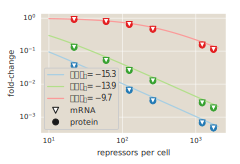

In [22]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_p.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)

# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo = (1 + r_array / Nns * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo,
             label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(data.energy.unique()[0]),
             color=colors[i * 2])
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.repressors.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')
    # mRNA
    plt.plot(data.repressors.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[(i * 2) + 1], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend()

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'lacI_titration.pdf', bbox_inches='tight')
plt.savefig(figdir + 'lacI_titration.svg', bbox_inches='tight')

The small deviations between the kinetic and the thermodynamic picture come from the fact that the parameters as determined assume that the mRNA reaches steady state for both the single- and the double-promoter state, ignoring the changes in repressor copy number as the cell cycle progresses for example. But these deviations are within our experimental resolution, so the approximation seems to do a good job.

### IPTG titration 

Now that we know that the rates are able to reproduce the equilibrium picture of the LacI titration (up to a systematic deviation) let's complete the analysis of the equivalence between both frameworks by including the effect of the inducer.

For this analysis we will keep the operator fix and vary both the repressor copy number and the IPTG concentration.

Let's run the dynamics for several cell cycles while varying the inducer concentration.

In [23]:
# repressor-DNA binding energy
op = 'O2'
eRA = -13.9 # kBT

# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define IPTG concentrations
iptg_array = [0, 0.1, 5, 10, 25, 50, 75, 100, 500, 1000] # µM

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors', 'iptg_uM',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_iptg = pd.DataFrame(columns=names)

# Loop through operators
for j, iptg in enumerate(iptg_array):
    print(iptg)
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        A_reg_s = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off, 
                              rm, gm, rp, gp)
        # Two promoters
        A_reg_d = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off,
                              2 * rm, gm, rp, gp)

        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1
        
        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 100000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_reg_s, A_reg_d, expo_reg,
                           n_cycles,
                           states=['P', 'E', 'R'], n_steps=3000)

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information of the first moments
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]
        
        # Define array for integration
        a_array = np.linspace(0, 1, len(df_m_reg_first))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg,
                            m_mean, m_mean_unreg, fold_change_m,
                            p_mean, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_iptg = df_fc_iptg.append(series, ignore_index=True)

0
0.1
5
10
25
50
75
100
500
1000


Let's plot the inducer titration to compare the predictions done by the equilibrium picture and the kinetic model with this new variation.

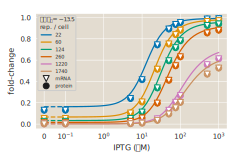

In [27]:
# Define IPTG range to compute thermodynamic fold-change
iptg = np.logspace(-1, 3, 50)
iptg_lin = [0, 0.1]

# Group data frame by repressor copy number
df_group = df_fc_iptg.groupby('repressors')

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Loop through each of the repressor copy numbers
for i, (rep, data) in enumerate(df_group):
    # Compute thermodynamic fold-change
    fc_thermo = (1 + rep / Nns * ccutils.model.p_act(iptg, ka, ki, epsilon) *
                 np.exp(- data.energy.unique()[0]))**-1
    fc_thermo_lin = (1 + rep / Nns * ccutils.model.p_act(iptg_lin, ka, ki, epsilon) *
                 np.exp(- data.energy.unique()[0]))**-1
    
    # Plot thermodynamic fold-change prediction
    plt.plot(iptg, fc_thermo, label=str(rep), color=colors[i])
    plt.plot(iptg_lin, fc_thermo_lin, label='', color=colors[i],
             linestyle='--')
    
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.iptg_uM.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[i], label='')
    # mRNA
    plt.plot(data.iptg_uM.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[i], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')
    
# Change scale to log
plt.xscale('symlog', linthreshx=1E-1, linscalex=0.5)

# Label axis
plt.xlabel(r'IPTG ($\mu$M)')
plt.ylabel('fold-change')

# Set legend
legend = plt.legend(title=r'$\beta\Delta\epsilon_r =  -13.5$' '\n rep. / cell',
                    fontsize=5)
plt.setp(legend.get_title(),fontsize=6)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'IPTG_titration.pdf', bbox_inches='tight')
plt.savefig(figdir + 'IPTG_titration.svg', bbox_inches='tight')

## Systematic moment computation

Now that we confirmed that these parameters can reproduce the equilibrium picture let's systematically obtain average moments for varying repressor copy numbers, operators and inducer concentrations that later on we will use to compute the maximum entropy approximation of the distribution.

We will generate and export a tidy data frame containing all moments.

### Varying number of repressors, 12 IPTG concentrations.

Let's now list the parameters that will be varied for the different strains. Here we will perform the calculations for a range of repressor copy numbers and the 12 inducer concentrations used experimentally.

In [28]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, np.log10(2000), 50)
repressors = np.unique(repressors.round(0))

# Include repressor copy numbers for experimentally available strains
rep = [0, 22, 60, 124, 260, 1220, 1740]
# Add them to list
repressors =  np.sort(np.concatenate([repressors, rep]))

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Now given these parameters let's integrate the moment equations and then compute the average moment over the cell cycle as we have done so far for the first moment.

In [30]:
# Boolean indicating if computation should be performed
compute_constraints = False
if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]         

    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)


    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        A_reg_s = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off, 
                              rm, gm, rp, gp)
        # Two promoters
        A_reg_d = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off,
                              2 * rm, gm, rp, gp)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_reg_s, A_reg_d, expo_reg,
                           n_cycles,
                           states=['P', 'E', 'R'], n_steps=5000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(datadir + 'MaxEnt_multi_prom_constraints.csv',
              index=False)

df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_prom_constraints.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,m5p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,0.0,0.0,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
1,O1,-15.3,0.0,0.1,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
2,O1,-15.3,0.0,5.0,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
3,O1,-15.3,0.0,10.0,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
4,O1,-15.3,0.0,25.0,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24


### Varying IPTG concenrations, experimental repressor copy number.

Now we will expand these calculations for the experimental strains, i.e. three operators and three repressor copy numbers. The difference will be that here we will have a finer range of inducer concentrations.

In [31]:
# Define experimental concentrations in µM
inducer = np.logspace(-1, np.log10(5000), 49) # µM
inducer = np.insert(inducer, 0, 0)

# Define repressor copy numebers
repressors = [0, 22, 260, 1740]

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Now given these parameters let's integrate the moment equations and then compute the average moment over the cell cycle as we have done so far for the first moment.

In [32]:
# Boolean indicating if computation should be performed
compute_constraints = False
if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]         

    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)

    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        A_reg_s = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off, 
                              rm, gm, rp, gp)
        # Two promoters
        A_reg_d = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off,
                              2 * rm, gm, rp, gp)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_reg_s, A_reg_d, expo_reg,
                           n_cycles,
                           states=['P', 'E', 'R'], n_steps=5000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(datadir + 'MaxEnt_multi_prom_IPTG_range.csv',
              index=False)

df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_prom_IPTG_range.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,m5p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,0,0.000000,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
1,O1,-15.3,0,0.100000,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
2,O1,-15.3,0,0.125284,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
3,O1,-15.3,0,0.156961,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24
4,O1,-15.3,0,0.196646,0.999999,14.413104,281.447304,6944.69389,205634.038508,7.028696e+06,...,7.583822e+11,3.374801e+14,1.880664e+17,1.375361e+20,7.295123e+10,2.349825e+13,8.988287e+15,4.125147e+18,2.330372e+21,1.701840e+24


### Extending the repressor copy number count.

We now extend our calculations to have a higher repressor copy number in order to explore the predictions of the model at much higher repressor counts.

In [33]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, 6, 100)
repressors = np.unique(repressors.round(0))

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Having defined the extended range, let's perform the computation.

In [34]:
# Boolean indicating if computation should be performed
compute_constraints = True
if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]         

    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)


    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        A_reg_s = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off, 
                              rm, gm, rp, gp)
        # Two promoters
        A_reg_d = A_mat_p_lam(kr_on, kr_off, kp_on, kp_off,
                              2 * rm, gm, rp, gp)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_reg_s, A_reg_d, expo_reg,
                           n_cycles,
                           states=['P', 'E', 'R'], n_steps=5000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(datadir + 'MaxEnt_multi_prom_ext_R.csv',
              index=False)

### Comparing constraints with single-promoter model.

An interesting question is how we expect the moments to change with respect to a kinetic model in which the variability in gene copy number along the cell cycle is ignored.

The first interesting quantity to compare will be the first moments of mRNA and protein. We expect these to be quite similar, with different numerical values, but similar qualitative behavior.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


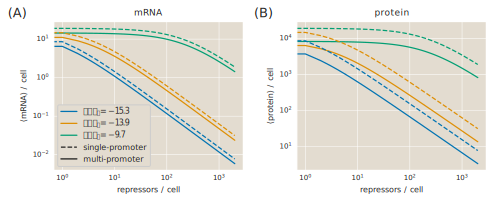

In [20]:
# Load moments for multi-promoter level
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_prom_constraints.csv')

# Read constraints for the single promoter model
df_constraints_single = pd.read_csv(datadir +
                                    'MaxEnt_ss_constraints.csv')
# Remove Oid
df_constraints_single = df_constraints_single\
                        [df_constraints_single.operator != 'Oid']

# Group both by binding energy
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('binding_energy')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('binding_energy')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, data.m1p0, 
               label=r'$\beta\Delta\epsilon_r = {:.1f}$'.format(group), color=colors[i])
    ax[1].plot(data.repressor, data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend()

# Add letter label to subplots
plt.figtext(0.01, 0.9, '(A)', fontsize=13)
plt.figtext(0.5, 0.9, '(B)', fontsize=13)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'first_mom_comparison.pdf', bbox_inches='tight')

As expected the mRNA first moment are basically the same since given the fast degradation rate this molecule is basically at steady state for the most part during both phases in the multi-promoter case. For the protein we have that the multi promoter model has systematically less protein than the single promoter case. This is because since protein never reaches the steady state for the two-promoter case it doesn't have as much as one would expect from the steady state assumption.

#### Noise

Let's now look at the noise defined as
$$
\text{noise} \equiv {\text{STD}(X) \over \ee{X}},
$$
where $\text{STD}(x)$ is the standard deviation of the random variable $X$. The reason for choosing this metric over the commonly used Fano factor is that when quantified from experimental data this is a dimensionless quantity that can be directly inferred from arbitrary units of fluorescence as long as there is a linear relationship between these arbitrary units and the absolute molecule count.

The expectation here is that since having multiple promoters increases the variability over the cell cycle, the multi-promoter model should have a higher noise.

Let's first compute this quantity along with the fold-change for both the mRNA and protein level

In [21]:
# Load moments for multi-promoter level
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_prom_IPTG_range.csv')

# Read constraints for the single promoter model
df_constraints_single = pd.read_csv(datadir +
                                    'MaxEnt_ss_constraints.csv')
# Remove Oid
df_constraints_single = df_constraints_single\
                        [df_constraints_single.operator != 'Oid']

# Find the mean unregulated levels to compute the fold-change
mean_m_delta = np.mean(df_constraints_single[df_constraints_single.repressor ==
                                             0].m1p0)
mean_p_delta = np.mean(df_constraints_single[df_constraints_single.repressor ==
                                             0].m0p1)

# Compute the noise for the single-promoter data
df_constraints_single = \
df_constraints_single.assign(m_noise=np.sqrt(df_constraints_single.m2p0 - 
                                             df_constraints_single.m1p0**2) / 
                                             df_constraints_single.m1p0,
                             p_noise=np.sqrt(df_constraints_single.m0p2 - 
                                             df_constraints_single.m0p1**2) / 
                                             df_constraints_single.m0p1,
                       m_fold_change=df_constraints_single.m1p0 / mean_m_delta,
                       p_fold_change=df_constraints_single.m0p1 / mean_p_delta)

# Find the mean unregulated levels to compute the fold-change
mean_m_delta = np.mean(df_constraints[df_constraints.repressor==0].m1p0)
mean_p_delta = np.mean(df_constraints[df_constraints.repressor==0].m0p1)

# Compute the noise for the multi-promoter data
df_constraints = df_constraints.assign(m_noise=np.sqrt(df_constraints.m2p0 - 
                                                       df_constraints.m1p0**2) / 
                                                       df_constraints.m1p0,
                               p_noise=np.sqrt(df_constraints.m0p2 - 
                                               df_constraints.m0p1**2) / 
                                               df_constraints.m0p1,
                               m_fold_change=df_constraints.m1p0 / mean_m_delta,
                               p_fold_change=df_constraints.m0p1 / mean_p_delta)

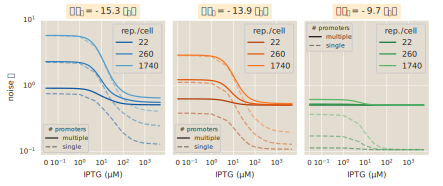

In [34]:
# Define repressor copy numbers to include
rep = [22, 260, 1740]

# Group moments by operator and repressor
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

df_group_single = df_constraints_single[df_constraints_single['repressor'].\
                  isin(rep)].sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Define energies to go along operators
energies = [-15.3, -13.9, -9.7]

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                                   n_colors=len(rep) + 3)[0:3]))

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', alpha=0.5)

# Define location for secondary legend
leg2_loc = ['lower left'] * 2 + ['upper left']
for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    single, = ax[i].plot([], [], color='k', linestyle='--', label='',
               alpha=0.5)
    multi, = ax[i].plot([], [], color='k', label='')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
    ax[i].set_yscale('log')
    ax[i].set_ylim(top=10)
    # Set legend
    leg1 = ax[i].legend(title='rep./cell', fontsize=8)
    # Set legend font size
    plt.setp(leg1.get_title(), fontsize=8)
    # leg1 will be removed from figure
    leg2 = ax[i].legend([multi, single], ['multiple', 'single'],
                        loc=leg2_loc[i],
                        fontsize=6, title='# promoters')
    # Set legend font size
    plt.setp(leg2.get_title(), fontsize=6)
    # Manually add the first legend back
    ax[i].add_artist(leg1)
    
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise $\eta$')

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'noise_comparison.pdf', bbox_inches='tight')
plt.savefig(figdir + 'noise_comparison.svg', bbox_inches='tight')

## Comparison with experimental data

In order to asses if our dynamical theory for the moments works we will compare experimentally determined moments to our theoretical predictions.

For this we need to read the microscopy data gathered so far.

In [35]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*IPTG*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria
##  (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)]

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,date,operator,rbs,mean_intensity,intensity
0,20181018,O2,auto,88.876915,502.830035
1,20181018,O2,auto,99.759342,393.291230
2,20181018,O2,auto,94.213193,552.315421
3,20181018,O2,auto,92.993102,426.131591
4,20181018,O2,auto,94.591855,455.251678


Consider that the noise is defined as
\begin{equation}
\text{noise} \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle}.
\end{equation}
Assume that the intensity level of a cell $I$ is linearly proportional to the absolute protein count, i.e.
$$
I = \alpha p,
$$
where $\alpha$ is the proportionality constant between arbitrary units (a.u.) and protein count. Substituting this definition on the noise gives
\begin{equation}
\text{noise} = {\sqrt{\left\langle (\alpha I)^2 \right\rangle - 
                   \left\langle \alpha I \right\rangle^2} \over 
                   \left\langle \alpha I \right\rangle}.
\end{equation}
Since $\alpha$ is a constant it can be taken out of the average operator $\ee{\cdot}$, obtaining
\begin{equation}
\text{noise} = {\sqrt{\alpha^2 \left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \alpha \left\langle  I \right\rangle}
     = {\sqrt{\left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \left\langle  I \right\rangle}
\end{equation}

The proportionality between intensity and protein count has no intercept. This ignores the autofluorescence that cells without
reporter would generate. Therefore in practice to compute the noise from experimental intensity measurements we compute
\begin{equation}
\text{noise} = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

Having shown that this quantity is dimensionless we can therefore compare the experimentally determined noise with our theoretical predictions. Let's begin with the unregulated promoter.

### Unregulated promoter

Let's first take the intensity measurements of the $\Delta lacI$ strains and compute the noise.

In [36]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns in data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
        'rbs', 'repressors', 'mean', 'std', 'noise']

# Initialize data frame to save the noise
df_noise_delta = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'delta']
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise_delta = df_noise_delta.append(strain_info, ignore_index=True)
    
df_noise_delta.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161203,0.0,O2,-13.9,delta,0,18001.490853,6721.517791,0.373387
1,20180326,0.0,O2,-13.9,delta,0,8854.573359,3889.388878,0.439252
2,20180326,5000.0,O2,-13.9,delta,0,10612.993079,3433.252510,0.323495
3,20180327,0.0,O3,-9.7,delta,0,11336.540930,5664.678541,0.499683
4,20180327,5000.0,O3,-9.7,delta,0,9885.637629,3528.154358,0.356897


Now let's plot the noise for each of the operators along with the theoretical prediction for the multi-promoter model. In principle there shouldn't be any difference between operators since these are all unregulated promoters. But it it known that basepairs downstream the RNAP binding site can affect transcriptional output as well. We ignore this in the model, but to make sure here we will plot each $\Delta lacI$ strain separatade by operators.

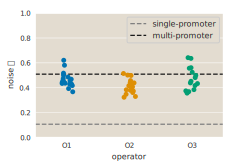

In [38]:
# Extract theoretical noise for the ∆lacI strain
noise_delta_thry = df_constraints[df_constraints.repressor == 0].p_noise.mean()
noise_delta_thry_single = df_constraints_single\
                         [df_constraints_single.repressor == 0].p_noise.mean()

# Initialize figure
fig = plt.figure()

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
colors = [sns.color_palette(x, n_colors=1) for x in col_list]

# Plot theoretical prediction

# Generate stripplot for experimentally determined 
# noise of the ∆lacI strain
sns.stripplot(x='operator', y='noise',
            order=['O1', 'O2', 'O3'], data=df_noise_delta)

# Plot theoretical prediction as a horizontal black line
plt.axhline(noise_delta_thry_single, color='gray', linestyle='--',
            label='single-promoter')
plt.axhline(noise_delta_thry, color='k', linestyle='--',
            label='multi-promoter')

# Include legend
plt.legend()

# Set axis limits
plt.ylim([0, 1])

# Label axis
plt.ylabel(r'noise $\eta$')


# Save figure
plt.tight_layout()
plt.savefig(figdir + 'noise_delta_microscopy.pdf', bbox_inches='tight')

The prediction matches very well the experimental data and there is not a clear trend from any of the operators.

### Regulated promoter

Let's extend the analysis to the regulated promoter. Again we will take the single-cell intensity measurements, extract the auto fluorescence and compute the noise $\eta$.

We will also compute the fold-change with respect to the unregulated promoter since later on we will compare these two predictions - noise and fold-change - side to side.

In [39]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns of data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
         'rbs', 'repressors', 'mean', 'std', 'noise', 'fold_change']
# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Obtain the unregulated mean expression to compute
    # the fold-change
    mean_delta = np.mean(df_noise_delta[df_noise_delta.date == date]['mean'])
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Compute fold-change
            strain_info.append(strain_info[
            int(np.where(np.array(names) == 'mean')[0])] / mean_delta)
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise = df_noise.sort_values('repressors')
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise,fold_change
76,20180411,50.0,O1,-15.3,HG104,22,7113.775463,3441.463223,0.483775,0.616047
86,20180412,10.0,O1,-15.3,HG104,22,2537.301906,1672.347015,0.659104,0.196951
85,20180412,5.0,O1,-15.3,HG104,22,1002.920580,1023.894658,1.020913,0.077849
84,20180412,0.1,O1,-15.3,HG104,22,575.998191,590.389315,1.024985,0.044710
83,20180412,0.0,O1,-15.3,HG104,22,547.753909,481.302582,0.878684,0.042518


Let's now plot the noise $\eta$ as a function of the IPTG concentration for all strains measured experimentally. Here we will show with a solid line the predictions made by the model that accoutns for gene copy number variability during the cell cycle, and with a dotted line the predictions for the single promoter model.

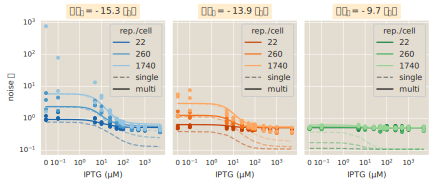

In [40]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[df_noise.noise > 0].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_constraints_single[df_constraints_single['repressor'].isin(rep)].\
                  sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3]))

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_noise, linestyle='--',
                              alpha=0.5,
                              color=col_dict[group[0]][group[1]],
                              label='')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    ax[op_idx[group[0]]].plot(data.IPTG_uM, data.noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=3)


for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    ax[i].plot([], [], color='k', linestyle='--', label='single',
               alpha=0.5)
    ax[i].plot([], [], color='k', label='multi')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
    ax[i].set_yscale('log')
    # Set legend
    leg = ax[i].legend(title='rep./cell', fontsize=8)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise $\eta$')

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

# plt.tight_layout()
plt.savefig(figdir + 'noise_comparison_exp.pdf', bbox_inches='tight')
plt.savefig(figdir + 'noise_comparison_exp.svg', bbox_inches='tight')

The predictions from the multi-promoter model are very good except for some of the points for the strongest binding site with the most number of repressors. These cells, being the most repressed ones have values close to the autofluorescence background that we expect from cells. Therefore when computing the mean fluorescence value after subtracting the autofluorescence the numbers can be either very small or even negative.

But these points draw too much attention away from the main point of the figure. Still we do not want to explicitly discard these points. We will therefore generate a plot with two different scales to "zoom in" to the relvant part of the plot while still showing the entirety of the data set.

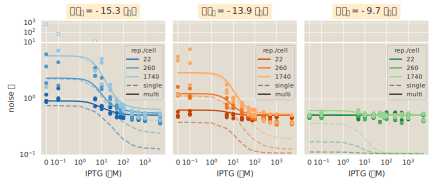

In [41]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[df_noise.noise > 0].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_constraints_single[df_constraints_single['repressor'].isin(rep)].\
                  sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3]))

# Initialize figure
fig, ax = plt.subplots(2, 3, figsize=(7, 2.5), sharex=True, sharey='row',
                       gridspec_kw={'height_ratios':[1, 5], 'wspace':0.05,
                                    'hspace': 0})
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    ax[op_idx[group[0]] + 3].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    ax[op_idx[group[0]] + 3].plot(data.inducer_uM, data.p_noise, linestyle='--',
                              alpha=0.5,
                              color=col_dict[group[0]][group[1]],
                              label='')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                  data[data.noise <= 10].noise,
                                  linestyle='--',
                                  color=col_dict[group[0]][group[1]],
                                  label='', lw=0, marker='o', markersize=3)
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM, 
                              data[data.noise > 10].noise, 
                              linestyle='--', color='w', label='', lw=0,
                              marker='o', markersize=3,
                              markeredgecolor=col_dict[group[0]][group[1]])

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
ax[0].set_yscale('log')
ax[3].set_yscale('log')

# Set limits of reference plots and the rest will folow
ax[3].set_ylim([1E-1, 10])
ax[0].set_ylim([10, 2E3])

# Set ticks for the upper plot
ax[0].set_yticks([1E2, 1E3])

# Add "fake plots" for the single and multi promoter legend
for i in range(3):
    # Generate legend for single vs double promoter
    ax[i + 3].plot([], [], color='k', linestyle='--', label='single',
               alpha=0.5)
    ax[i + 3].plot([], [], color='k', label='multi')
    # Set legend
    leg = ax[i + 3].legend(title='rep./cell', fontsize=6)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=6)
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i + 3].set_xlabel(r'IPTG ($\mu$M)')
ax[3].set_ylabel(r'noise $\eta$')   

# Save figure
plt.savefig(figdir + 'noise_comparison_exp_scale.pdf', bbox_inches='tight')
plt.savefig(figdir + 'noise_comparison_exp_scale.svg', bbox_inches='tight')

#### fold-change & noise side to side

Let's now look at the fold-change and the noise simultaneously to show that the theory can capture both the first and the second moment.

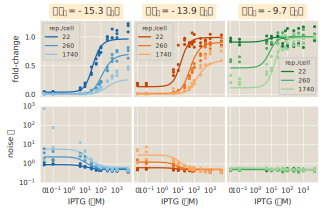

In [42]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep,sns.color_palette(col_list[i], 
                                                  n_colors=len(rep) + 1)[0:3]))

# Initialize figure
fig, ax = plt.subplots(2, 3, figsize=(5, 3), sharex=True, sharey='row')

# Linearize plot numeration
ax = ax.ravel()

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    ax[op_idx[group[0]]].plot(data.inducer_uM, data.p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    
    # Plot noise
    ax[op_idx[group[0]] + 3].plot(data.inducer_uM, data.p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax[op_idx[group[0]] + 3].plot(data.IPTG_uM, data.noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)


for i, a in enumerate(ax):
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)
    # Set specifics for fold-change plots
    if i < 3:
        # Set title
        label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
        ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
        # Set legend
        leg = ax[i].legend(title='rep./cell', fontsize=6)
        # Set legend font size
        plt.setp(leg.get_title(), fontsize=6)
    # Set specifics for noise plots
    else:
        ax[i].set_yscale('log')
        ax[i].set_ylim(bottom=1E-1)
        # Label axis
        ax[i].set_xlabel(r'IPTG ($\mu$M)')
    
ax[0].set_ylabel(r'fold-change')
ax[3].set_ylabel(r'noise $\eta$')

# Change spacing between plots
plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.savefig(figdir + 'moment_comparison_exp.pdf', bbox_inches='tight')
plt.savefig(figdir + 'moment_comparison_exp.svg', bbox_inches='tight')

Again let's change the scale of the lower row to emphasize less those outliers. This plot will require a lot of manipulation of `GridSpec` given the necessary separation between subplots.

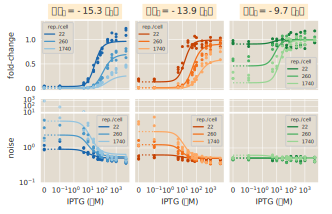

In [55]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3]))

# Set threshold to separate linear and logarithmic scale    
thresh = 1E-1

fig = plt.figure(figsize=(5, 3))
# Define outer grispec to keep at top the fold-change and at the bottom
# the noise
gs_out = mpl.gridspec.GridSpec(2, 1, height_ratios = [1, 1 + 1/5],
                               hspace=.1, wspace=0.05)

#make nested gridspecs
gs_fc = mpl.gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_out[0],
                                             wspace=0.05)
gs_noise = mpl.gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs_out[1],
                                                wspace=0.05, hspace=.01,
                                                height_ratios=[1, 5])

# Add axis to plots
# fold-change
ax_fc = [plt.subplot(gs) for gs in gs_fc]
# noise
ax_noise = [plt.subplot(gs) for gs in gs_noise]

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    # Linear
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                 data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                 data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    
    # Plot noise
    # Linear
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                        data[data.inducer_uM <= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                        data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax_fc[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change,
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                        data[data.noise <= 10].noise,
                                        color=col_dict[group[0]][group[1]],
                                        label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM,
                                    data[data.noise > 10].noise,
                                    color='w',
                                    markeredgecolor=col_dict[group[0]][group[1]],
                                    label='', lw=0, marker='o',
                                    markersize=2)

##  Set shared axis

# fold-change
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_fc[i]
    # join axis with first plot
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_fc[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Remove x ticks from left plot
plt.setp(ax_fc[0].get_xticklabels(), visible=False)   
# Set axis to be shared with left lower plot
ax_fc[0].get_shared_x_axes().join(ax_fc[0], ax_noise[3])

# noise upper
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_noise[i]
    # join x axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    # join y axis with upper left plot 
    ax.get_shared_y_axes().join(ax, ax_noise[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Set upper left plot x axis to be shared with lower left plot
ax.get_shared_x_axes().join(ax_noise[0], ax_noise[3])
# Remove x ticks from left plot
plt.setp(ax_noise[0].get_xticklabels(), visible=False)   

# noise lower 
# Loop through axis
for i in range(4, 6):
    # Select axis
    ax = ax_noise[i]
    # join axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_noise[3])
    # Remove y ticks labels
    plt.setp(ax.get_yticklabels(), visible=False)   

# Set scales of reference plots and the other ones will follow
ax_noise[3].set_xscale('symlog', linthreshx=thresh)#, linscalex=0.5)
ax_noise[0].set_yscale('log')
ax_noise[3].set_yscale('log')

# Set limits
for i in range(3):
    ax_fc[i].set_ylim([-0.05, 1.4])

ax_noise[0].set_ylim([1E1, 2E3])
ax_noise[3].set_ylim([1E-1, 1E1])

# Label axis
for i, ax in enumerate(ax_fc):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
    ax.set_title(label, bbox=dict(facecolor='#ffedce'))
    # Set legend
    leg = ax.legend(title='rep./cell', fontsize=5)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=5)
    leg2 = ax_noise[i + 3].legend(title='rep./cell', fontsize=5,
                                  loc='upper right')
    plt.setp(leg2.get_title(), fontsize=5)
    
    ax_noise[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    
# Set ticks for the upper noise plot
ax_noise[0].set_yticks([1E2, 1E3])
ax_noise[1].set_yticks([1E2, 1E3])
ax_noise[2].set_yticks([1E2, 1E3])
   
# Add y axis labels    
ax_fc[0].set_ylabel(r'fold-change')
ax_noise[3].set_ylabel(r'noise')

# Align y axis labels
fig.align_ylabels()

plt.savefig(figdir + 'moment_comparison_exp_scale.pdf', bbox_inches='tight')
plt.savefig(figdir + 'moment_comparison_exp_scale.svg', bbox_inches='tight')

---
---

# Compare to experimental data

Let's now take a look at the experimental data to compare it with these theoretical predictions.

Let's first load the data into memory.

In [ ]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

# Compute the total intensity by multiplying area times mean intensity
df_micro.loc[:, 'intensity'] = df_micro['area'] * df_micro['mean_intensity']
df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

## Normalizing data by $\left\langle \Delta lacI \right\rangle$.

In order to make the x axis comparable we will normalize each data set by the mean fluorescence value of the $\Delta lacI$ strain, and will do the same for the theoretical results.

In [ ]:
# Compute the mean autofluorescence for each experimental data set
df_auto_mean = df_micro[df_micro.rbs == 'auto'].groupby(['date'])[['mean_intensity', 'intensity']].mean()

# Compute the mean ∆lacI fluorescence for each expeirmental data set
df_delta_mean = df_micro[df_micro.rbs == 'delta'].groupby(['date'])[['mean_intensity', 'intensity']].mean()

# Extract the raw data of regulated repressors
df = df_micro[(df_micro.rbs != 'auto') & (df_micro.rbs != 'delta')]

# Add column with auto and ∆lacI values for both total and mean intensity
df.loc[:, 'auto_mean'] = df_auto_mean.loc[df.date, 'mean_intensity'].values
df.loc[:, 'auto_tot'] = df_auto_mean.loc[df.date, 'intensity'].values
df.loc[:, 'delta_mean'] = df_delta_mean.loc[df.date, 'mean_intensity'].values
df.loc[:, 'delta_tot'] = df_delta_mean.loc[df.date, 'intensity'].values

# Add the normalized intensity column
df.loc[:, 'norm_intensity_mean'] = (df.mean_intensity - df.auto_mean) /\
                              (df.delta_mean - df.auto_mean)
df.loc[:, 'norm_intensity_tot'] = (df.intensity - df.auto_tot) /\
                              (df.delta_tot - df.auto_tot)

df.head()

Let's look at one of these strains to make sure that the computation worked.

First let's compare the fold-change computed from the mean intensity vs. the total intensity.

In [ ]:
# Generate data frame in long format
df_example = df.loc[df.date == 20180402,
                    ('IPTG_uM', 'norm_intensity_mean', 'norm_intensity_tot')]

# Melt data frame into long format in order to use it
# with Violin plot function
df_example = pd.melt(df_example, id_vars=['IPTG_uM'])

# Initialize figure
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='IPTG_uM', y='value', hue='variable', data=df_example)
plt.xlabel('IPTG (µM)')
plt.ylabel('fold-change')
plt.tight_layout()

In [ ]:
# Plot example experimental data

df_example = df[df.date == 20180402]

# List the unique concentrations for this strain
concentrations = df_example.IPTG_uM.unique()

# Set a color pallete for each concentration
colors = sns.color_palette("Blues_r", n_colors=len(concentrations))

# Group data frame by concentration
df_group = df_example.groupby('IPTG_uM')

# Initialize figure
fig, ax = plt.subplots(1, 1)

# Loop through concentrations plotting the ECDF at each step
for i, (c, data) in enumerate(df_group):
    # ECDF Plot
    x, y = chann_cap.ecdf(data.norm_intensity_tot)
    ecdf_plot = ax.plot(x, y, '.', label=str(c) + r' $\mu$M', color=colors[i])

ax.legend(bbox_to_anchor=(1.31, 1.0))
    
ax.set_xlabel('fold-change')
ax.set_ylabel('ECDF')

Let's now plot the same ECDF along with the normalized CDF predictions.

First we build the theoretical distribution from the Lagrange multipliers.

In [ ]:
# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 3E4)

# Extract the multipliers for a specific strain
df_sample = df_maxEnt[(df_maxEnt.operator == df_example.operator.unique()[0]) &
                      (df_maxEnt.repressor == df_example.repressors.unique()[0])]

# Group multipliers by inducer concentration
df_group = df_sample.groupby('inducer_uM')

# Initialize matrix to save probability distributions
Pp = np.zeros([len(df_group), len(protein_space)])

# Initialize array to save mean fold-change
fc_cme = np.zeros(len(df_group))

# Loop through each of the entries
for i, (group, data) in enumerate(df_group):
    # Select the Lagrange multipliers
    lagrange_sample =  data.loc[:, [col for col in data.columns 
                                         if 'lambda' in col]].values[0]

    # Compute distribution from Lagrange multipliers values
    Pp[i, :] = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, lagrange_sample,
                                              exponents=[(0, 1), (0, 2), (0, 3)]).T
    # Compute mean fold-change
    fc_cme[i] = sum(Pp[i, :] * protein_space) / p_mean_unreg

Now we plot the ECDF along with the theoretical CDF.

In [ ]:
# List the unique concentrations for this strain
concentrations = df_example.IPTG_uM.unique()

# Set a color pallete for each concentration
exp_colors = sns.color_palette("Blues_r", n_colors=len(concentrations))
thry_colors = sns.color_palette("Greens_r", n_colors=len(concentrations))

# Group data frame by concentration
df_group = df_example.groupby('IPTG_uM')

# Define binstep not to use all bins to render the plot
binstep = 100

# Initialize figure
fig, ax = plt.subplots(1, 1)
# Loop through concentrations
for i, (c, data) in enumerate(df_group):
    # ECDF Plot
    x, y = chann_cap.ecdf(data.norm_intensity_tot)
    ecdf_plot = ax.plot(x, y, '.', label=str(c) + r' $\mu$M', color=exp_colors[i])

    # CDF plot
    ax.plot(protein_space[0::binstep] / p_mean_unreg, 
            np.cumsum(Pp[i, :])[0::binstep],
            drawstyle='steps', color=thry_colors[i], linewidth=2) 

# ax.legend(bbox_to_anchor=(1.31, 1.0))
    
ax.set_xlabel('fold-change')
ax.set_ylabel('ECDF')

It is hard to make a clear comparision between these distributions. What we will try instead is to generate a *violin plot*. For this we will generate random samples for the theoretical prediction since the python functions take samples rather than PMFs to then apply KDE on these samples.

As a trial let's first plot the *violin plot* of only the data

In [ ]:
##  Compute thermodynamic fold-change  ##
# Extract the repressor copy number and binding energy
eRA = df_example.binding_energy.unique()
R = df_example.repressors.unique() * 2

# Define range for theoretical fold-change
iptg_array = np.logspace(-1, np.log10(5000))
iptg_lin = [0, 0.1]

# Compute theoretical fold-change
fc_thry = chann_cap.fold_change_statmech(iptg_array, R, eRA, ka, ki)
fc_thry_lin = chann_cap.fold_change_statmech(iptg_lin, R, eRA, ka, ki)

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 4))

##  Plot thermodynamic fold-change  ##
ax.plot(iptg_array, fc_thry, color='k', zorder=1)
ax.plot(iptg_lin, fc_thry_lin, color='k', linestyle='--', zorder=1)

# Group data by concentrations
df_group = df_example.groupby('IPTG_uM')

##  Plot violin plots of titration curves  ##
# Define width of the violin plot and transform into log scale
w = 0.13
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
# Loop through each concentration and plot the violin plot
for i, (c, data) in enumerate(df_group):
    # Define position
    position = np.array([c])
    # Generate violin plot
    vplot = ax.violinplot(data.norm_intensity, position,
                          widths=width(position, w), showmeans=True)
    # Change color (weird matplotlib way of dealing with this)
    for vp in vplot['bodies']:
        vp.set_color('b')
        vp.set_edgecolor('b')
        vp.set_alpha(0.6)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = vplot[partname]
        vp.set_edgecolor('b')
        vp.set_linewidth(2)

# Set axis labels
ax.set_xlabel('IPTG (µM)')
ax.set_ylabel('fold-change')
   
# Set xaxis as hyperlog
ax.set_xscale('symlog', linthreshx=1E-1, linscalex=0.5)

As a sanity check, let's compute the mean fold-change and plot it against the theoretical prediction from the statistical mechanical model.

In [ ]:
# Group values by IPTG concentration and compute the mean fold-change
df_fc = df_example.groupby('IPTG_uM').norm_intensity.mean()

# Extract the repressor copy number and binding energy
eRA = df_example.binding_energy.unique()
R = df_example.repressors.unique() * 2

# Define range for theoretical fold-change
iptg_array = np.logspace(-1, 5)
iptg_lin = [0, 0.1]

# Compute theoretical fold-change
fc_thry = chann_cap.fold_change_statmech(iptg_array, R, eRA, ka, ki)
fc_thry_lin = chann_cap.fold_change_statmech(iptg_lin, R, eRA, ka, ki)

# Plot theoretical fold-change
plt.plot(iptg_array, fc_thry, color='k')
plt.plot(iptg_lin, fc_thry_lin, color='k', linestyle='--')

# Plot fold-change vs IPTG concentration
plt.plot(df_fc.index.values, df_fc.values, lw=0, marker='o', 
         label='microscopy')
plt.plot(df_fc.index.values, fc_cme, lw=0, marker='v',
         label='kinetic model')

# Set axis labels
plt.xlabel(r'IPTG ($\mu$M)')
plt.ylabel('fold-change')

# Set xaxis as hyperlog
plt.xscale('symlog', linthreshx=1E-1, linscalex=0.5)

# Set y axis limits
plt.ylim([0, 1.2])

plt.legend()
plt.tight_layout()